<a href="https://colab.research.google.com/github/AdrianCobo/Deep-Learning-And-Artificial-Intelligence/blob/main/L6_Stock_Returns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [504]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Part 1: Price Prediction

In [505]:
# yes, you can read dataframes from URLs!
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [506]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [507]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [508]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1,1)

In [509]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx
scaler = StandardScaler()
# just the first half in order to not use test data in training
scaler.fit(series[:len(series) // 2]) 
series = scaler.transform(series).flatten()

In [510]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T ,1) # make it N x T x D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1239, 20, 1) Y.shape (1239, 1)


In [511]:
### try autoregressive RNN model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs 
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size = self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N,T,M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, (h0,c0))

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [512]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)

In [513]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [514]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [515]:
# Training
## full gradiant descent != batch gradient descent
## we use the full dataset because in this case, its small
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss 
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it + 1) % 5 == 0:
      print(f'Epoch  {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

  return train_losses, test_losses




In [516]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))

In [517]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [518]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 0.2239, Test Loss: 0.5852
Epoch  10/200, Train Loss: 0.0501, Test Loss: 0.2057
Epoch  15/200, Train Loss: 0.0208, Test Loss: 0.0846
Epoch  20/200, Train Loss: 0.0187, Test Loss: 0.0651
Epoch  25/200, Train Loss: 0.0135, Test Loss: 0.0393
Epoch  30/200, Train Loss: 0.0098, Test Loss: 0.0410
Epoch  35/200, Train Loss: 0.0082, Test Loss: 0.0397
Epoch  40/200, Train Loss: 0.0078, Test Loss: 0.0479
Epoch  45/200, Train Loss: 0.0070, Test Loss: 0.0354
Epoch  50/200, Train Loss: 0.0066, Test Loss: 0.0370
Epoch  55/200, Train Loss: 0.0062, Test Loss: 0.0315
Epoch  60/200, Train Loss: 0.0060, Test Loss: 0.0333
Epoch  65/200, Train Loss: 0.0059, Test Loss: 0.0281
Epoch  70/200, Train Loss: 0.0058, Test Loss: 0.0295
Epoch  75/200, Train Loss: 0.0057, Test Loss: 0.0255
Epoch  80/200, Train Loss: 0.0056, Test Loss: 0.0249
Epoch  85/200, Train Loss: 0.0055, Test Loss: 0.0233
Epoch  90/200, Train Loss: 0.0055, Test Loss: 0.0225
Epoch  95/200, Train Loss: 0.0054, Test Loss: 0

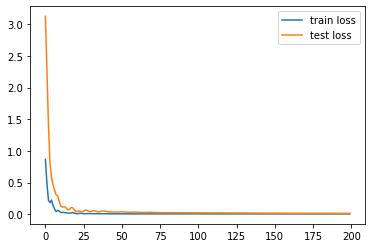

In [519]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [520]:
# One step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_test[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

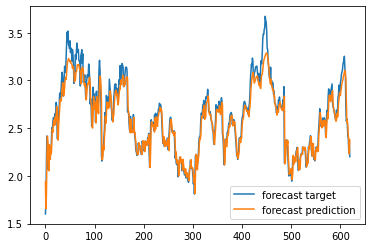

In [521]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [522]:
# # Multi-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

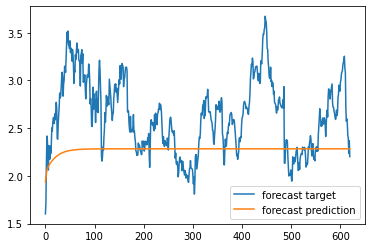

In [523]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 2: Returns

In [524]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [525]:
df.head()
# dont really matter that the 0 row is nan because we are going 
# to take 10 values to predict the eleventh and the first value dont 
# represent lot of info to predict the eleventh

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [526]:
# then the return is 
# (x[t] - x[t-1]/ x[t-1])
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [527]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


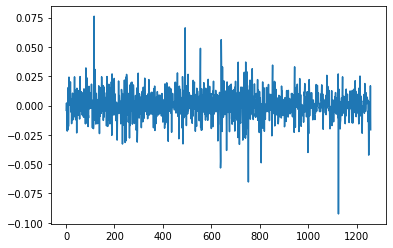

In [528]:
plt.plot(df['Return']);

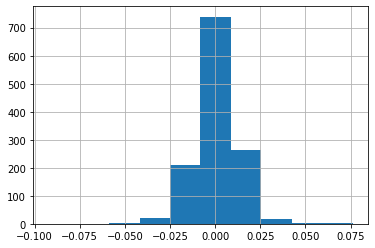

In [529]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [530]:
series = df['Return'].values[1:].reshape(-1,1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [531]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 20
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T ,1) # make it N x T x D
Y = np.array(Y).reshape(-1,1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [532]:
# Instantiate the model
model = RNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [533]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [534]:
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X[:-N//2].astype(np.float32()))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32()))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32()))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32()))

In [535]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [536]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test)

Epoch  5/200, Train Loss: 1.0549, Test Loss: 1.0773
Epoch  10/200, Train Loss: 1.0535, Test Loss: 1.0744
Epoch  15/200, Train Loss: 1.0519, Test Loss: 1.0697
Epoch  20/200, Train Loss: 1.0510, Test Loss: 1.0703
Epoch  25/200, Train Loss: 1.0498, Test Loss: 1.0736
Epoch  30/200, Train Loss: 1.0488, Test Loss: 1.0741
Epoch  35/200, Train Loss: 1.0476, Test Loss: 1.0729
Epoch  40/200, Train Loss: 1.0460, Test Loss: 1.0754
Epoch  45/200, Train Loss: 1.0440, Test Loss: 1.0758
Epoch  50/200, Train Loss: 1.0419, Test Loss: 1.0763
Epoch  55/200, Train Loss: 1.0396, Test Loss: 1.0809
Epoch  60/200, Train Loss: 1.0369, Test Loss: 1.0859
Epoch  65/200, Train Loss: 1.0346, Test Loss: 1.0921
Epoch  70/200, Train Loss: 1.0328, Test Loss: 1.0948
Epoch  75/200, Train Loss: 1.0306, Test Loss: 1.0966
Epoch  80/200, Train Loss: 1.0278, Test Loss: 1.0995
Epoch  85/200, Train Loss: 1.0243, Test Loss: 1.1035
Epoch  90/200, Train Loss: 1.0202, Test Loss: 1.1089
Epoch  95/200, Train Loss: 1.0156, Test Loss: 1

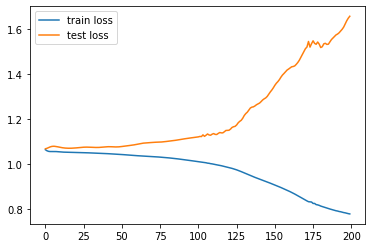

In [537]:
# Plot the train loss and testloss per iteraiton
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [538]:
# One step forecast using true targets

validation_target = Y
validation_predictions = []

X_on_device = torch.from_numpy(X.astype(np.float32)).to(device)

# index of firts validation input
i = 0

while len(validation_predictions) < len(validation_target):
  input_ = X_on_device[i].reshape(1,T,1) # since N and D = 1
  p = model(input_)[0,0].item() # 1x1 array -> scalar
  i += 1

  # update the predictions list
  validation_predictions.append(p)

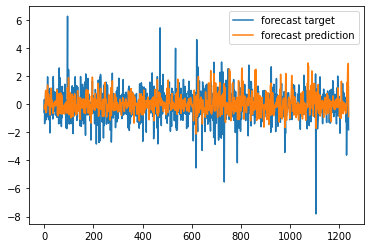

In [539]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [540]:
# # Multi-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# 1-D array of length T
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
  input_ = last_x.reshape(1,T,1)
  p = model(input_)
  #[0,0].item() # 1x1 array -> scalar

  # update the predictions list
  validation_predictions.append(p[0,0].item())

  # make the new input
  last_x = torch.cat((last_x[1:], p[0]))

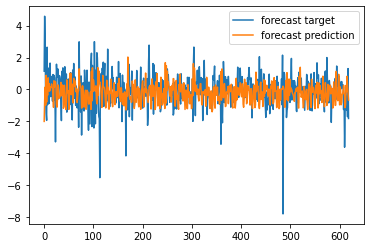

In [541]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 3: Binary Classification

In [542]:
# Now we are trying to predict if the price is going to go up or down, not the price
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [543]:
# Now make the actual data which will go into the neural network
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10 # the number of time steps to look at to make a prediction
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T = 10 and you have 11 data points then N = 1)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1238, 20, 1) Y.shape (1238, 1)


In [544]:
# Normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [545]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros((Ntrain, 1))

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [546]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros((N - Ntrain, 1))

for u in range(N - Ntrain):
  # u counts form 0 ... (N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [547]:
# Instantiate the model
model = RNN(n_inputs=5, n_hidden=20, n_rnnlayers=2, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(5, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [548]:
# Loss and optimizer - it's classification now!
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [549]:
# Make inputs and targets
# make inputs and targets
# we dont want to split out data randomly in this case because we want to predict
# the future
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(Y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(Y_test.astype(np.float32))

In [550]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [551]:
train_losses, test_losses = full_gd(model,criterion, optimizer,X_train, y_train, X_test, y_test, epochs=300)

Epoch  5/300, Train Loss: 0.6913, Test Loss: 0.6943
Epoch  10/300, Train Loss: 0.6885, Test Loss: 0.6930
Epoch  15/300, Train Loss: 0.6857, Test Loss: 0.6936
Epoch  20/300, Train Loss: 0.6837, Test Loss: 0.6974
Epoch  25/300, Train Loss: 0.6811, Test Loss: 0.7033
Epoch  30/300, Train Loss: 0.6768, Test Loss: 0.6996
Epoch  35/300, Train Loss: 0.6716, Test Loss: 0.7077
Epoch  40/300, Train Loss: 0.6661, Test Loss: 0.7079
Epoch  45/300, Train Loss: 0.6589, Test Loss: 0.7096
Epoch  50/300, Train Loss: 0.6512, Test Loss: 0.7110
Epoch  55/300, Train Loss: 0.6420, Test Loss: 0.7145
Epoch  60/300, Train Loss: 0.6387, Test Loss: 0.7190
Epoch  65/300, Train Loss: 0.6268, Test Loss: 0.7196
Epoch  70/300, Train Loss: 0.6207, Test Loss: 0.7463
Epoch  75/300, Train Loss: 0.6070, Test Loss: 0.7364
Epoch  80/300, Train Loss: 0.5944, Test Loss: 0.7622
Epoch  85/300, Train Loss: 0.5887, Test Loss: 0.7581
Epoch  90/300, Train Loss: 0.5683, Test Loss: 0.7742
Epoch  95/300, Train Loss: 0.5542, Test Loss: 0

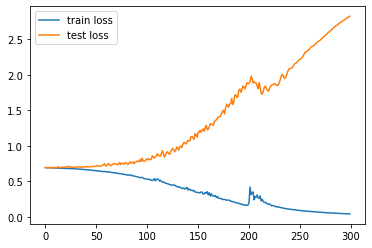

In [552]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [553]:
# Get accuracy
# for binary clasification, the worst accuracy is 50% because if your accuracy is 
# 0% you can just revers your output and have a 100% accuracy 
with torch.no_grad():
  p_train = model(X_train)
  p_train = (p_train.cpu().numpy() > 0)
  train_acc = np.mean(y_train.cpu().numpy() == p_train)

  p_test = model(X_test)
  p_test = (p_test.cpu().numpy() > 0)
  test_acc = np.mean(y_test.cpu().numpy() == p_test)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9917, Test acc: 0.5098
